# COMP4030 - Data Science and Machine Learning - Coursework 2

In [1]:
from utils.gestures import *

import numpy as np
import pandas as pd

Firstly we ensure that the raw data provided by Phyphox is unzipped and ready for import.

In [2]:
from utils.files import * 

process_all_zips()

No unprocessed files found for circle
No unprocessed files found for come
No unprocessed files found for go
No unprocessed files found for wave


Next we read the raw data from the CSV files and place the data inside a pandas DataFrame. We also use this opportunity to normalise our data using a MinMaxScaler, ensuring that all of our data lies between 0 and 1.

In [3]:
from utils.files import get_data_from_files

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()

df = get_data_from_files(scaler, 10) # 10 is the rows to trim from the beginning and end of the data
df

time   accel_x   accel_y   accel_z  accel_abs  file_number gesture
0     0.000000  0.559598  0.513468  0.226458   0.092301            1  circle
1     0.000728  0.568016  0.522626  0.197835   0.093494            1  circle
2     0.001457  0.517814  0.566211  0.222524   0.009878            1  circle
3     0.002185  0.484999  0.581607  0.242733   0.035518            1  circle
4     0.002913  0.510461  0.583776  0.212801   0.023593            1  circle
...        ...       ...       ...       ...        ...          ...     ...
8425  0.996293  0.185406  0.559236  0.457435   0.008318            2    come
8426  0.997220  0.189655  0.560508  0.459413   0.010630            2    come
8427  0.998146  0.194165  0.561389  0.461828   0.014358            2    come
8428  0.999073  0.191833  0.557005  0.462560   0.015793            2    come
8429  1.000000  0.191328  0.558699  0.457340   0.006974            2    come

[8430 rows x 7 columns]

Next we visualise our raw data for exploratory analysis

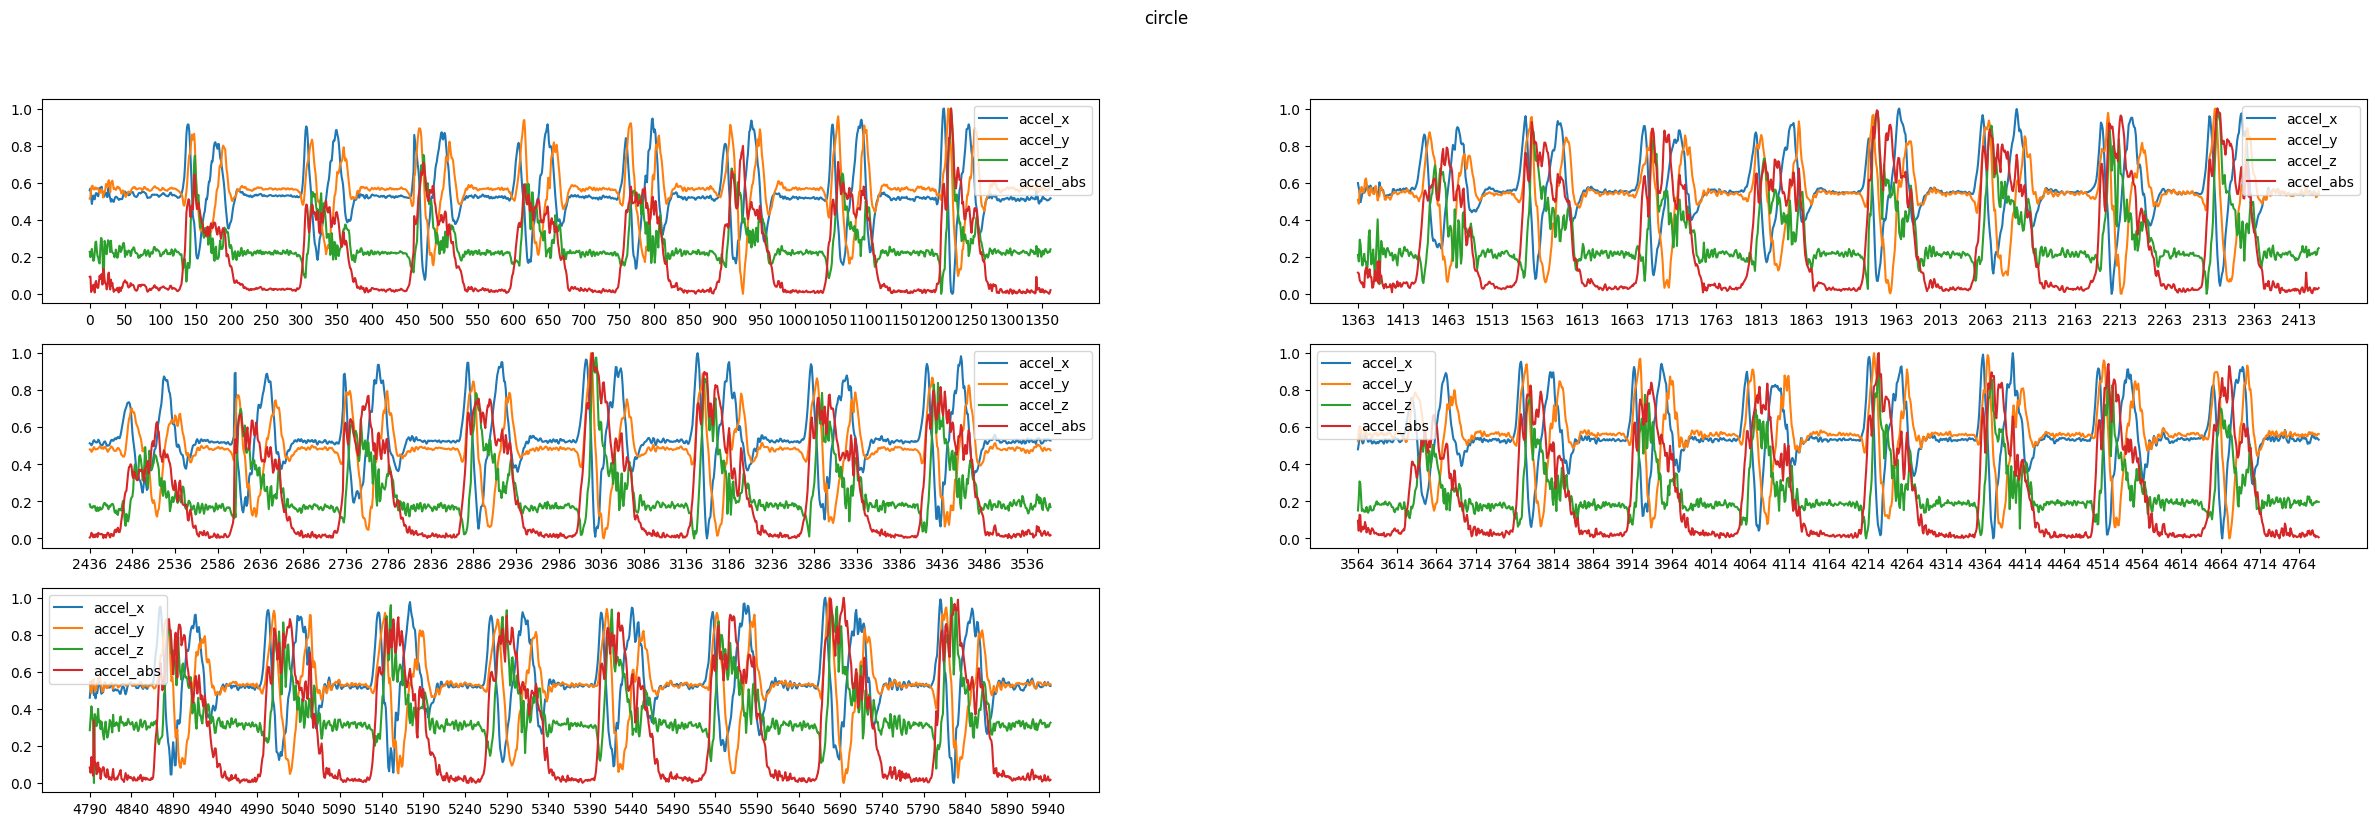

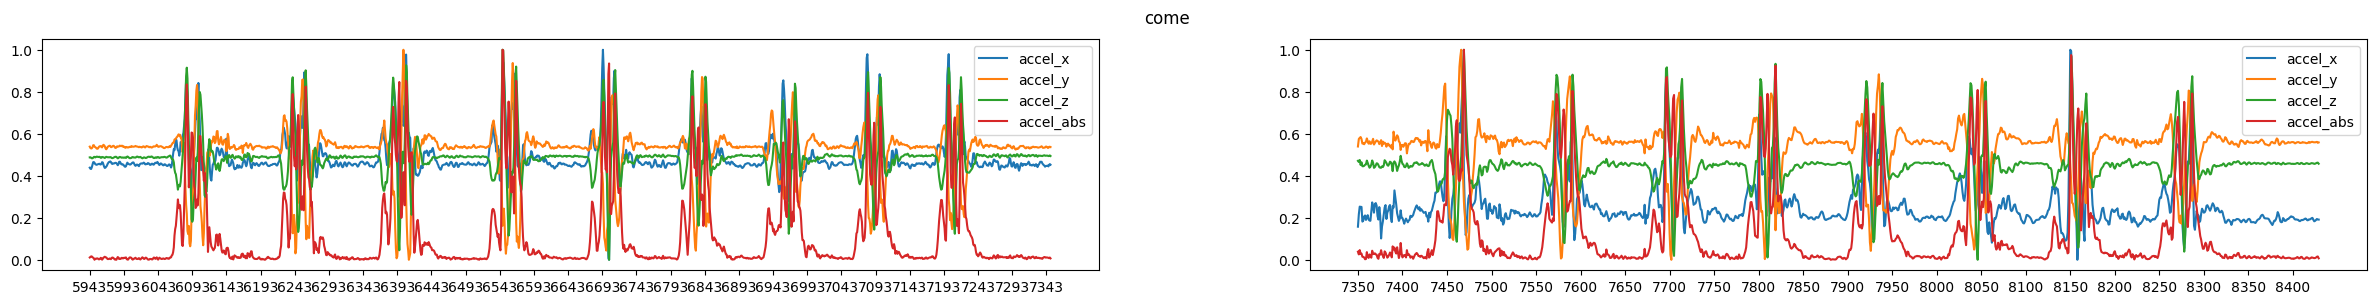

In [4]:
import math
import matplotlib.pyplot as plt

for gesture in get_gestures():
      
      group = df[df['gesture'] == gesture].groupby('file_number')
      
      if len(group) == 0:
            continue

      cols = 2
      rows = math.ceil(len(group) / cols)
      plt.figure(figsize=(cols * 15, rows * 3))

      for index, df_group in enumerate(group):
            plt.subplot(rows, cols, index + 1)
            for col in get_columns()[1:]:
                  plt.plot(df_group[1].index, df_group[1][col], label=col)
                  plt.xticks(range(df_group[1].index[0], df_group[1].index[-1], 50))
                  plt.legend()
      plt.suptitle(gesture)
      plt.show()

We then try to segment this data, using the dips in acceleration that we had purposefully included in our data captures.

Firstly we visualise just one example to inspect the rolling standard deviation and attempt to find the optimal parameters for slicing our data.

In [5]:
from utils.operations import *

rolling_window = 10
group_threshold = 10

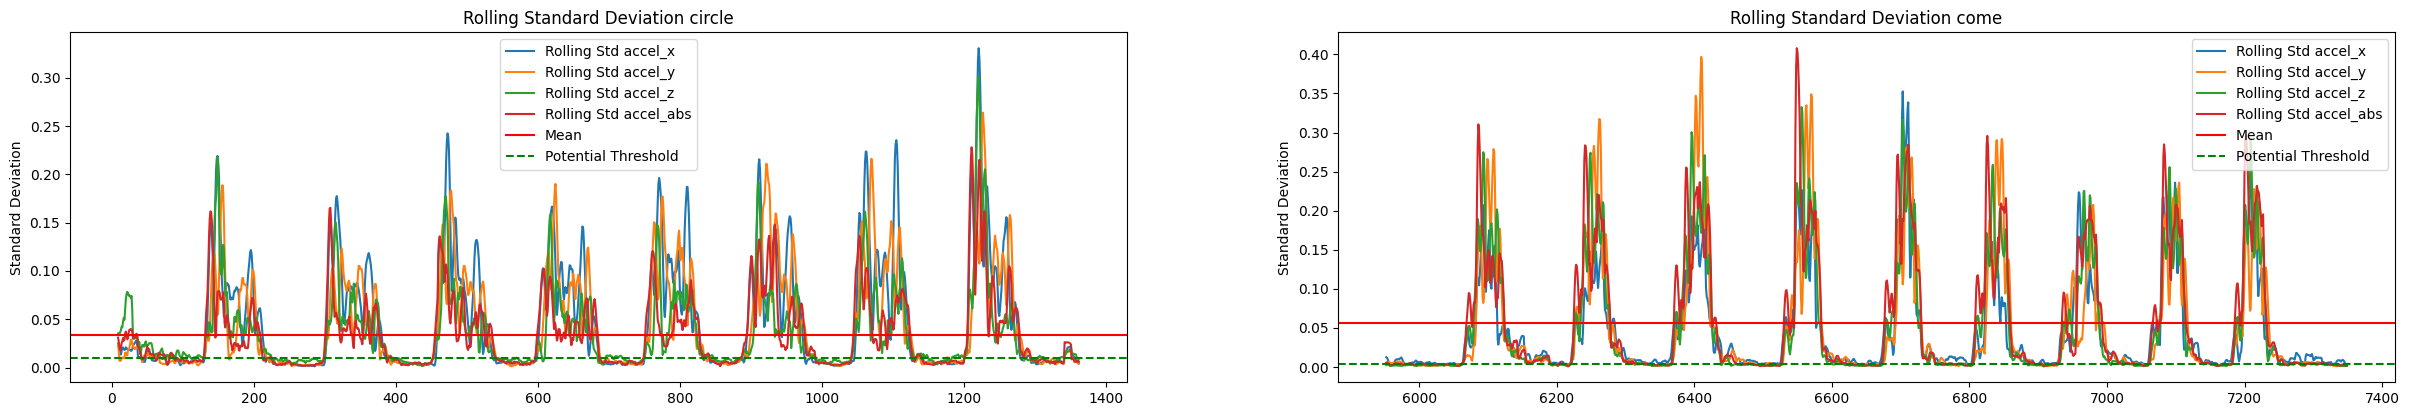

In [6]:
plt.figure(figsize=(30, 10))

for i, gesture in enumerate(get_gestures()):

      group = df[(df['gesture'] == gesture) & (df['file_number'] == 1)]
      if len(group) == 0:
            continue

      rolling_std = group['accel_abs'].rolling(window=rolling_window).std()
      threshold = rolling_std.mean() - rolling_std.std() / 1.5

      plt.subplot(2, 2, i + 1)

      for col in get_columns()[1:]:
            plt.plot(group[col].rolling(window=rolling_window).std(), label=f'Rolling Std {col}')

      plt.axhline(y=rolling_std.mean(), color='r', linestyle='-', label='Mean')
      plt.axhline(y=threshold, color='g', linestyle='--', label='Potential Threshold')    
      plt.title(f'Rolling Standard Deviation {gesture}')
      plt.ylabel('Standard Deviation')
      plt.legend()

plt.show()

Then we visualise our slices for all of the data.

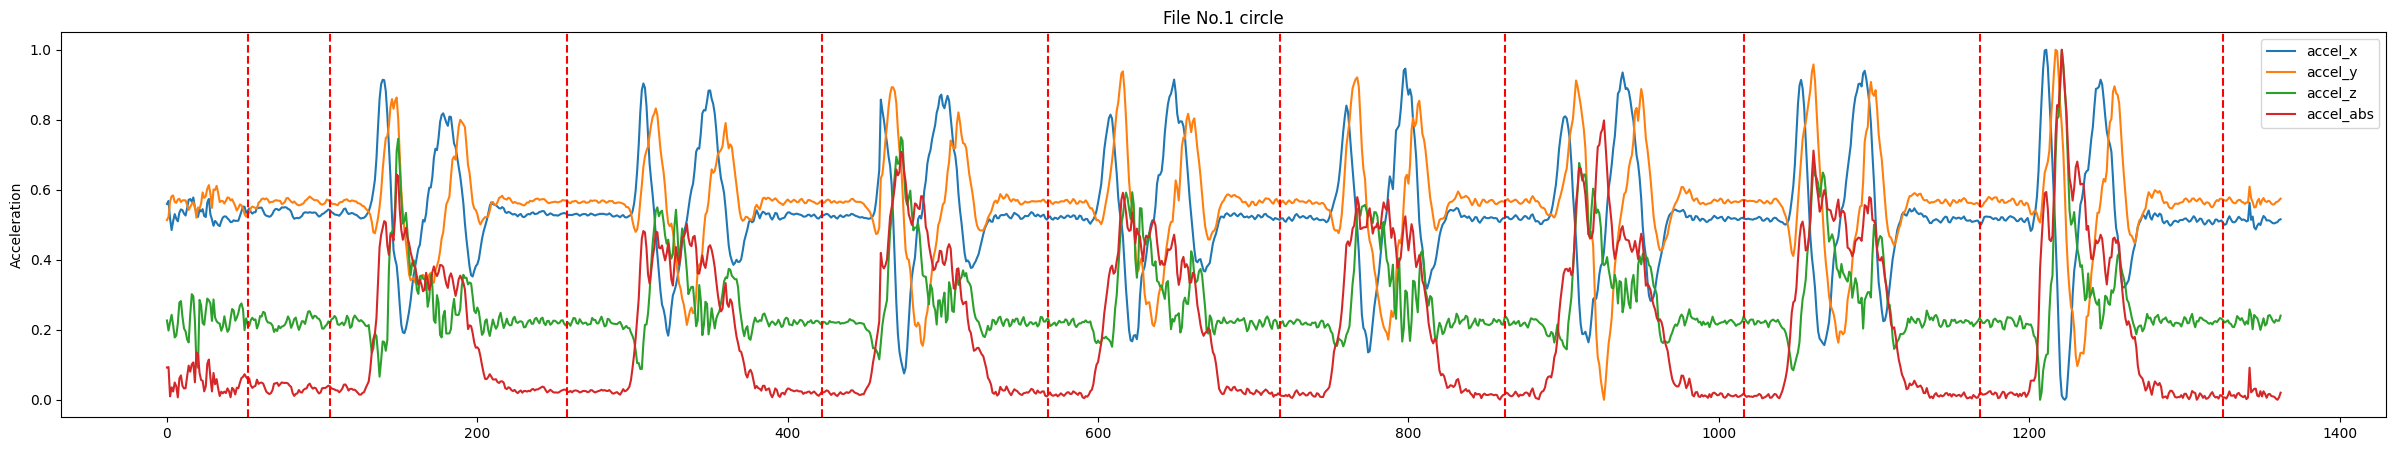

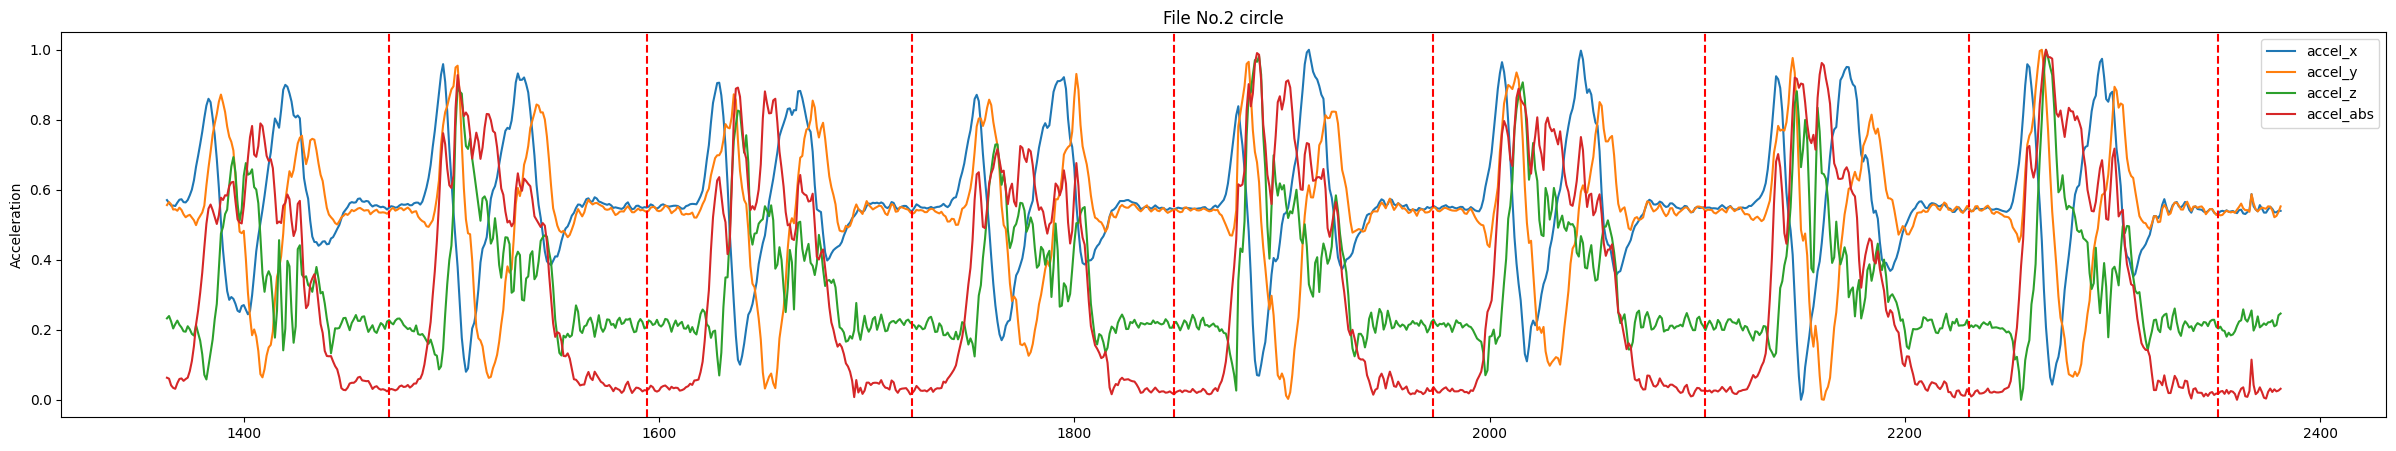

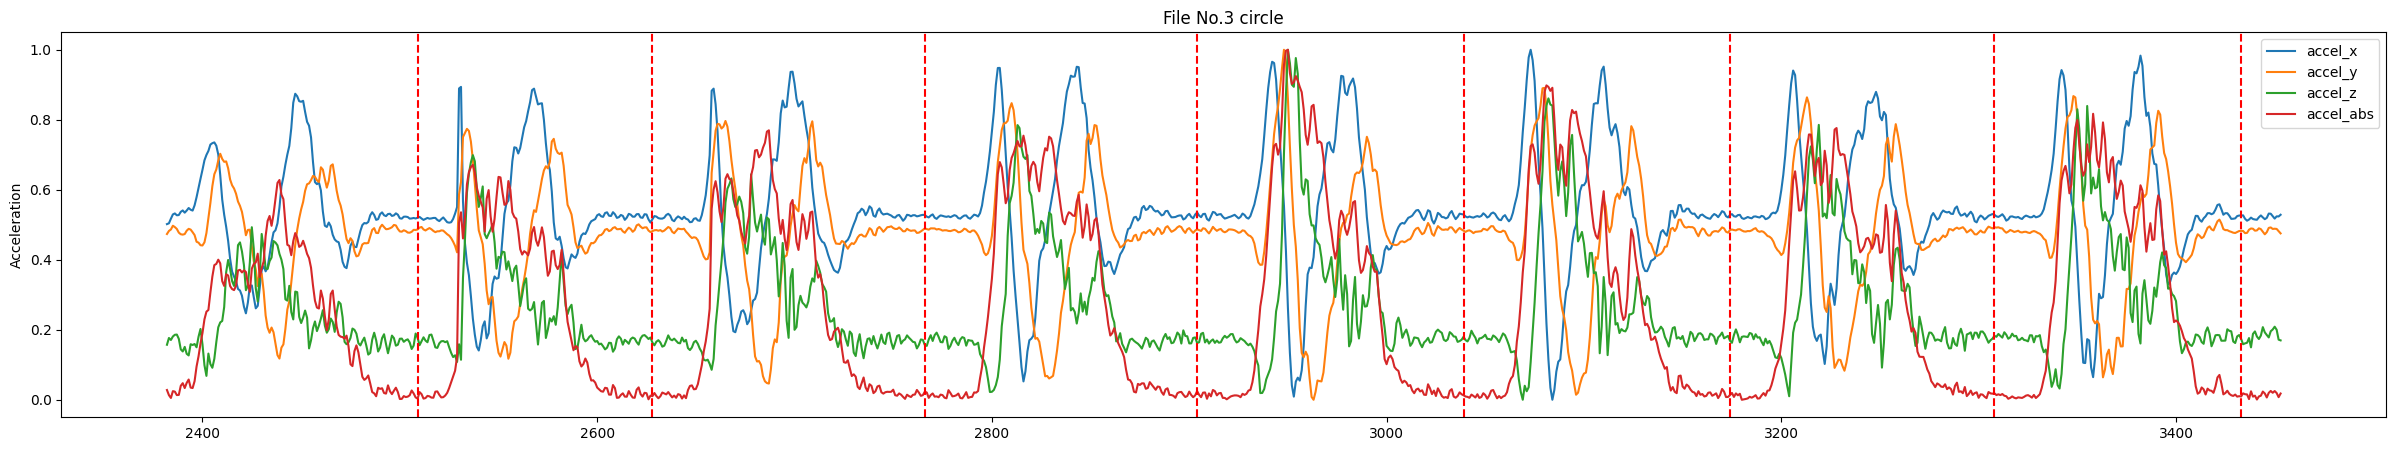

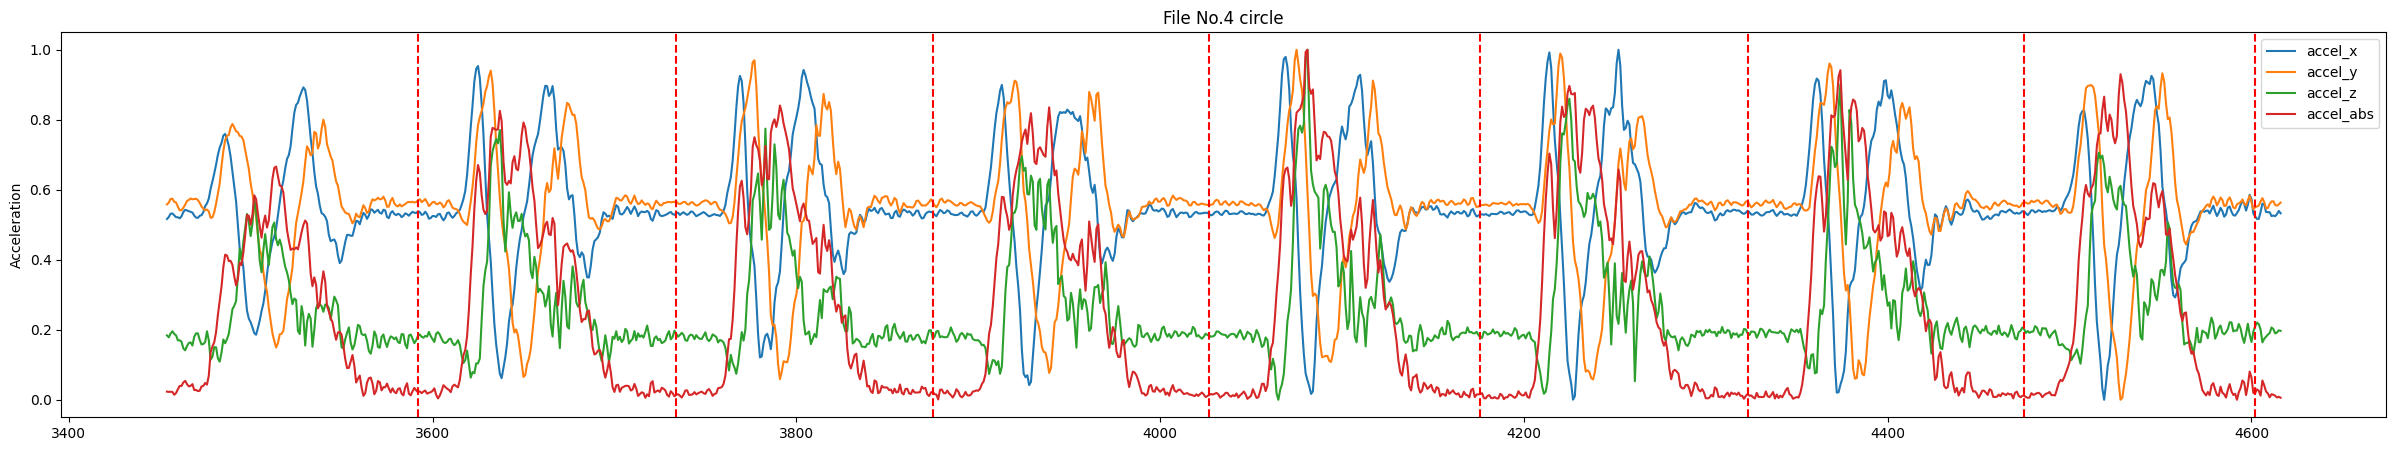

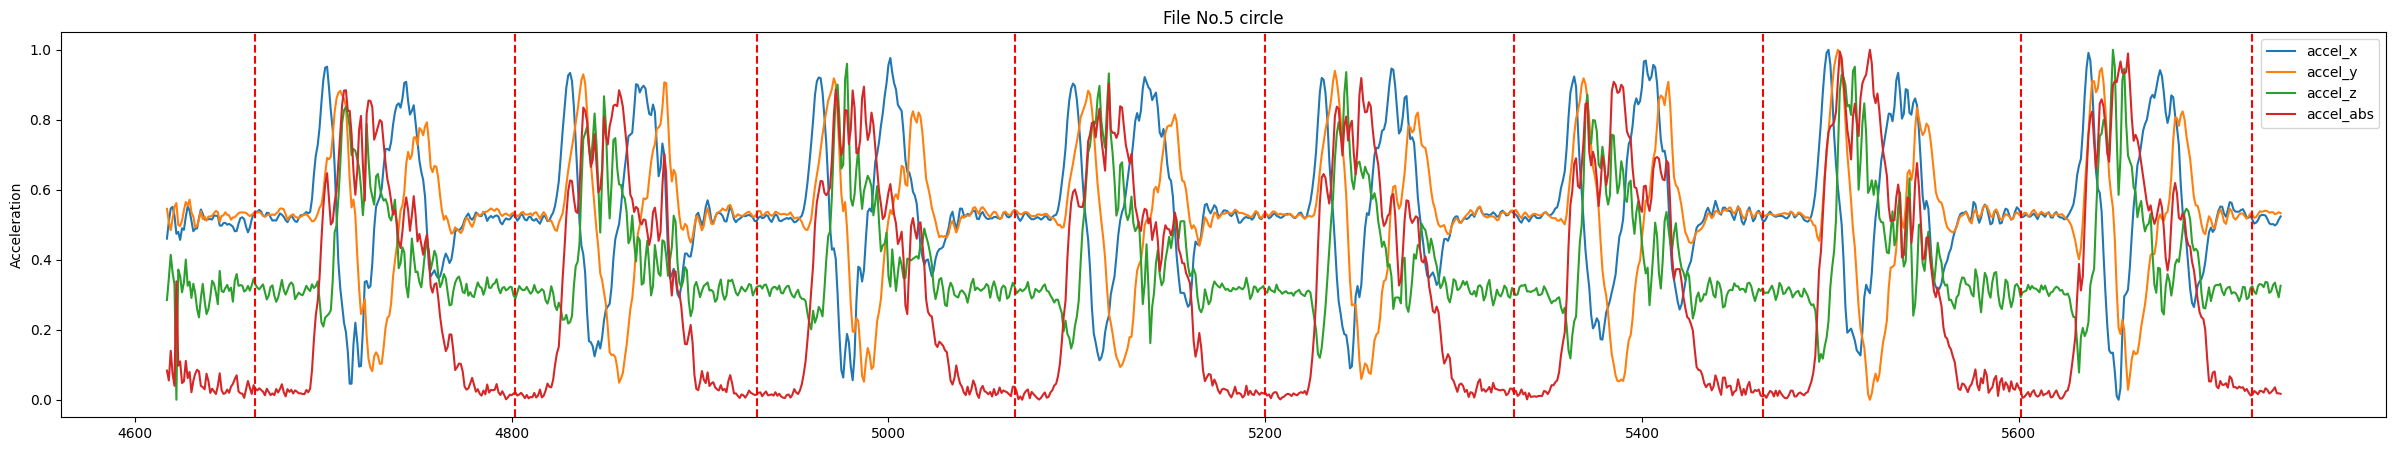

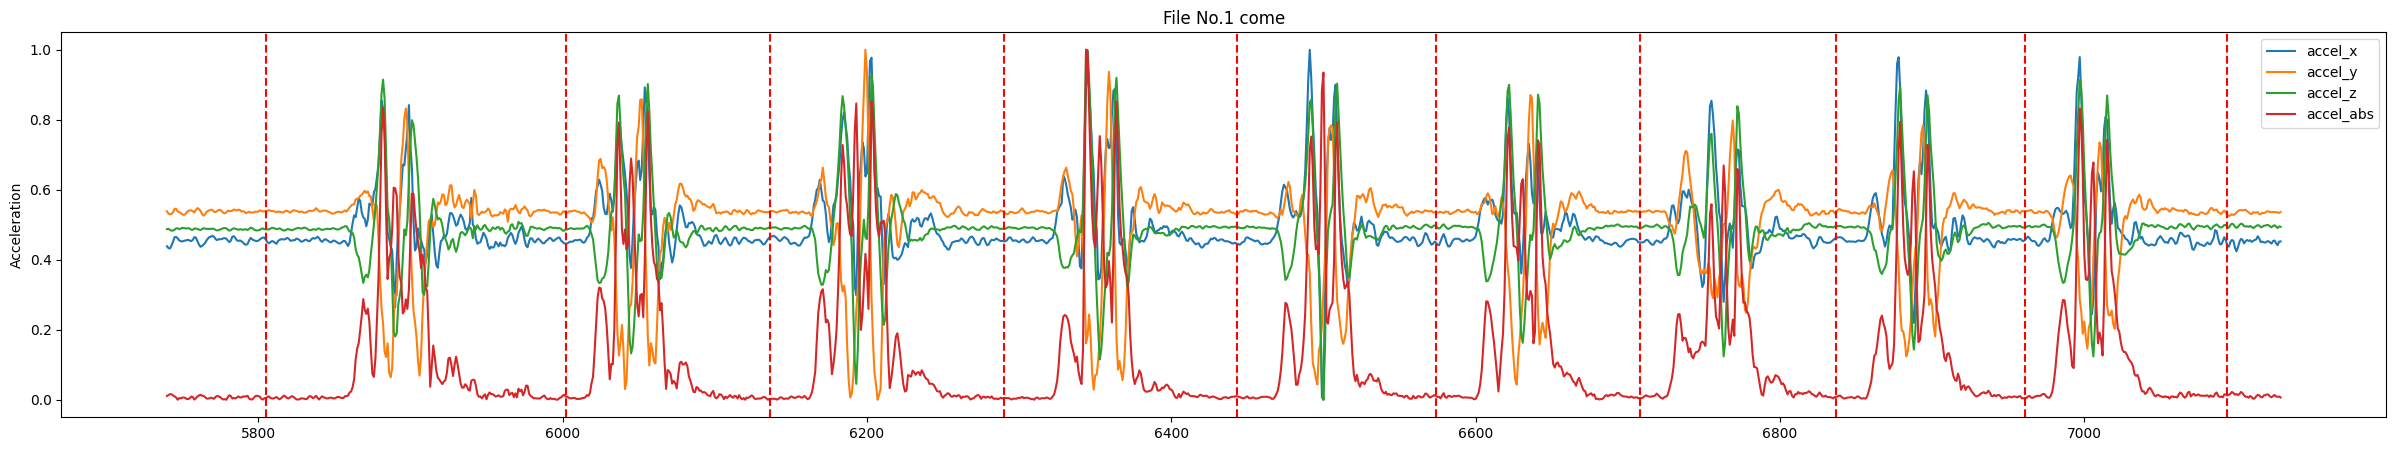

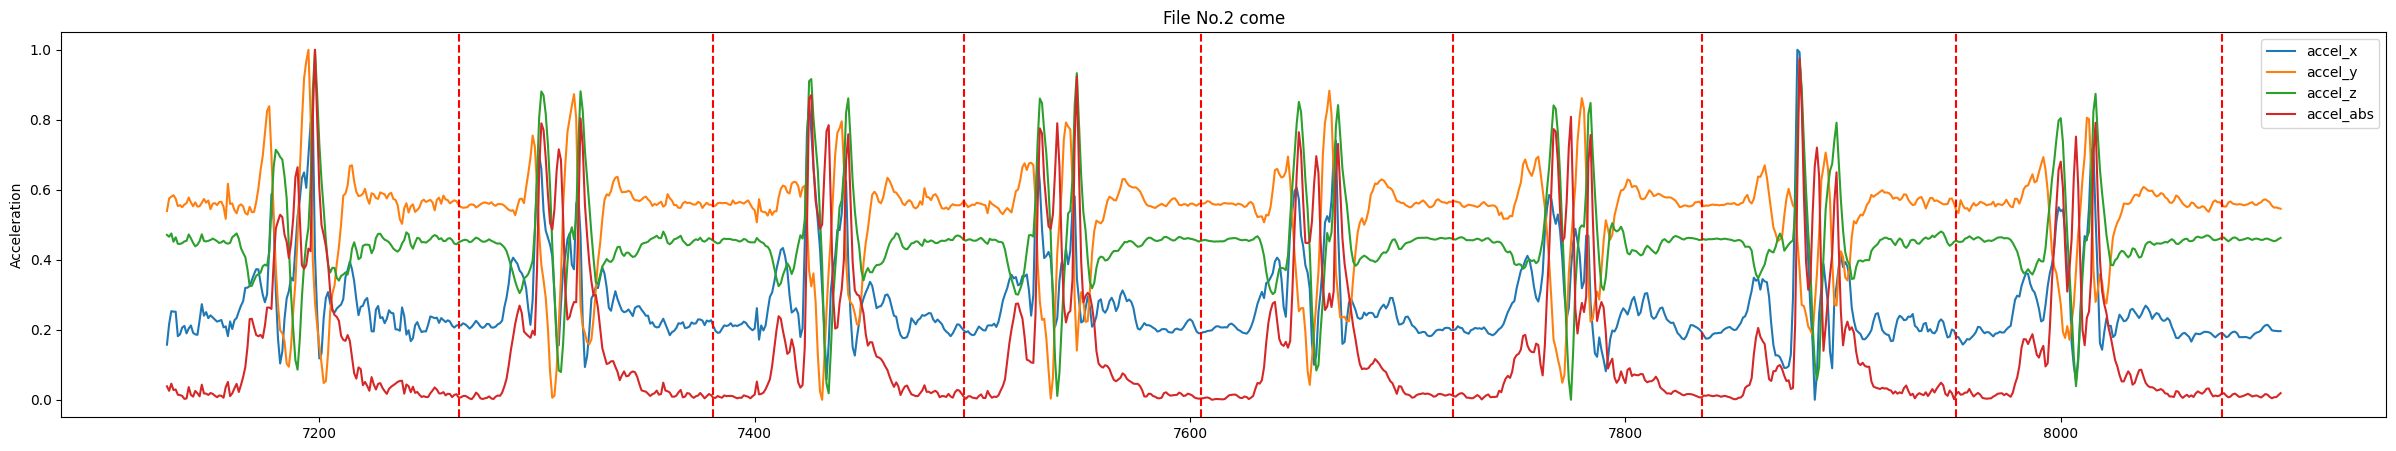

In [12]:
for gesture in get_gestures():
    d = df[df['gesture'] == gesture]
    for i, sub_group in d.groupby('file_number'):

        below_threshold = indices_below_threshold(sub_group, rolling_window, group_threshold)
        breakpoints = merge_and_average_integers(below_threshold, 25)

        plt.figure(figsize=(30, 5))
        
        for col in get_columns()[1:]:
            plt.plot(sub_group.index, sub_group[col], label=col)

        for index in breakpoints:
            plt.axvline(x=index, color='r', linestyle='--')

        plt.ylabel('Acceleration')
        plt.title(f'File No.{i} {gesture}')
        plt.legend()
        plt.show()

We can safely remove the data where the absolute acceleration never gets above a certain threshold.

In [8]:
drop_indices_where_data_never_exceeds(df, 'accel_abs',  0.3, rolling_window = 10, group_threshold = 5)

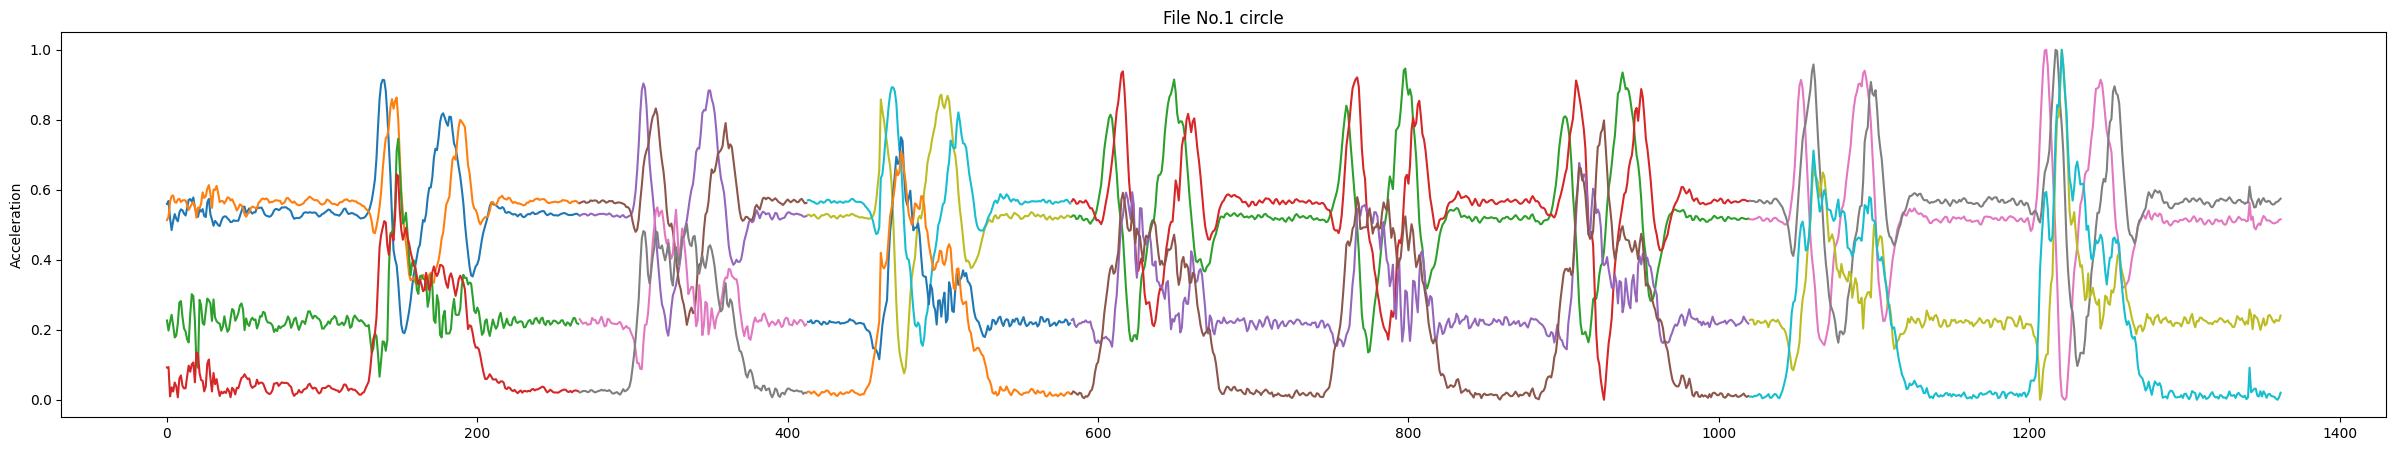

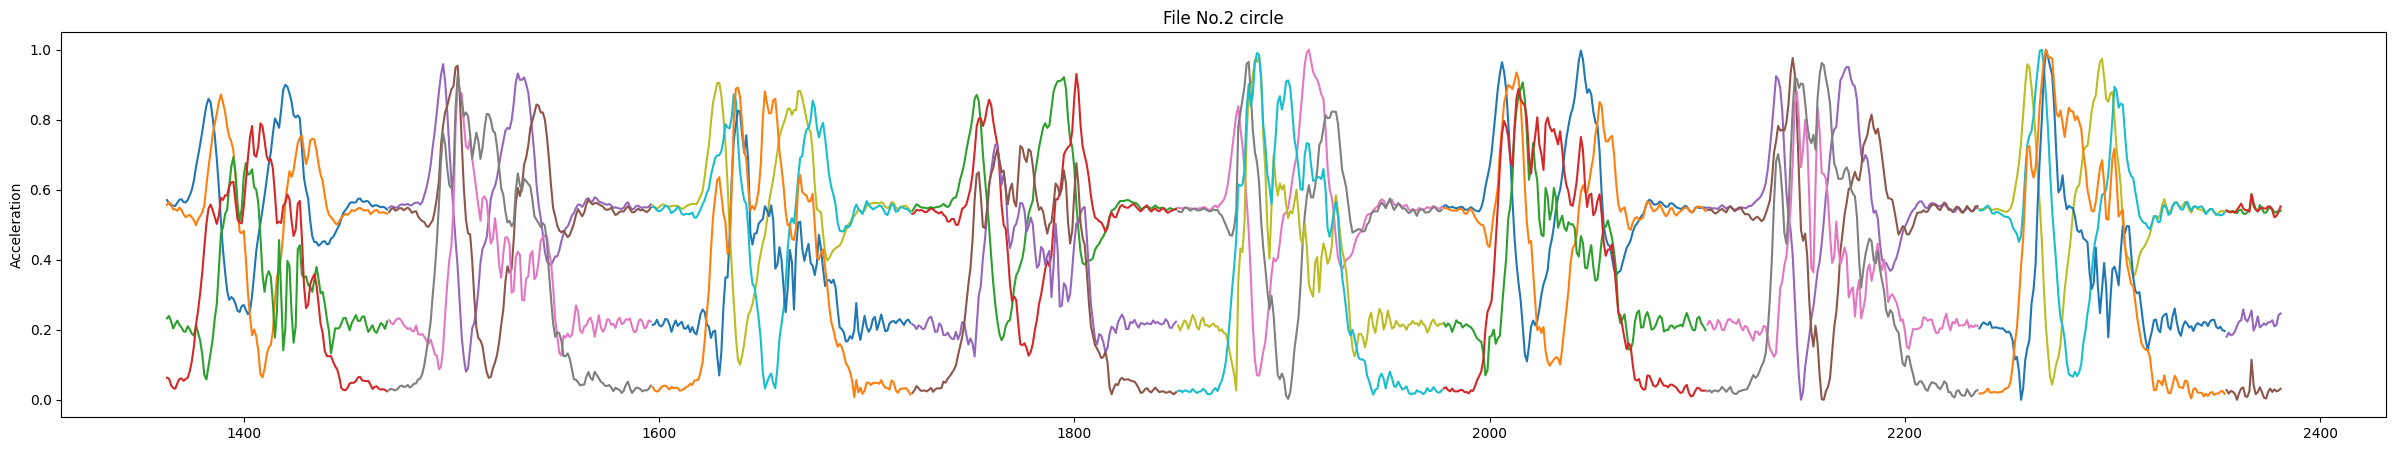

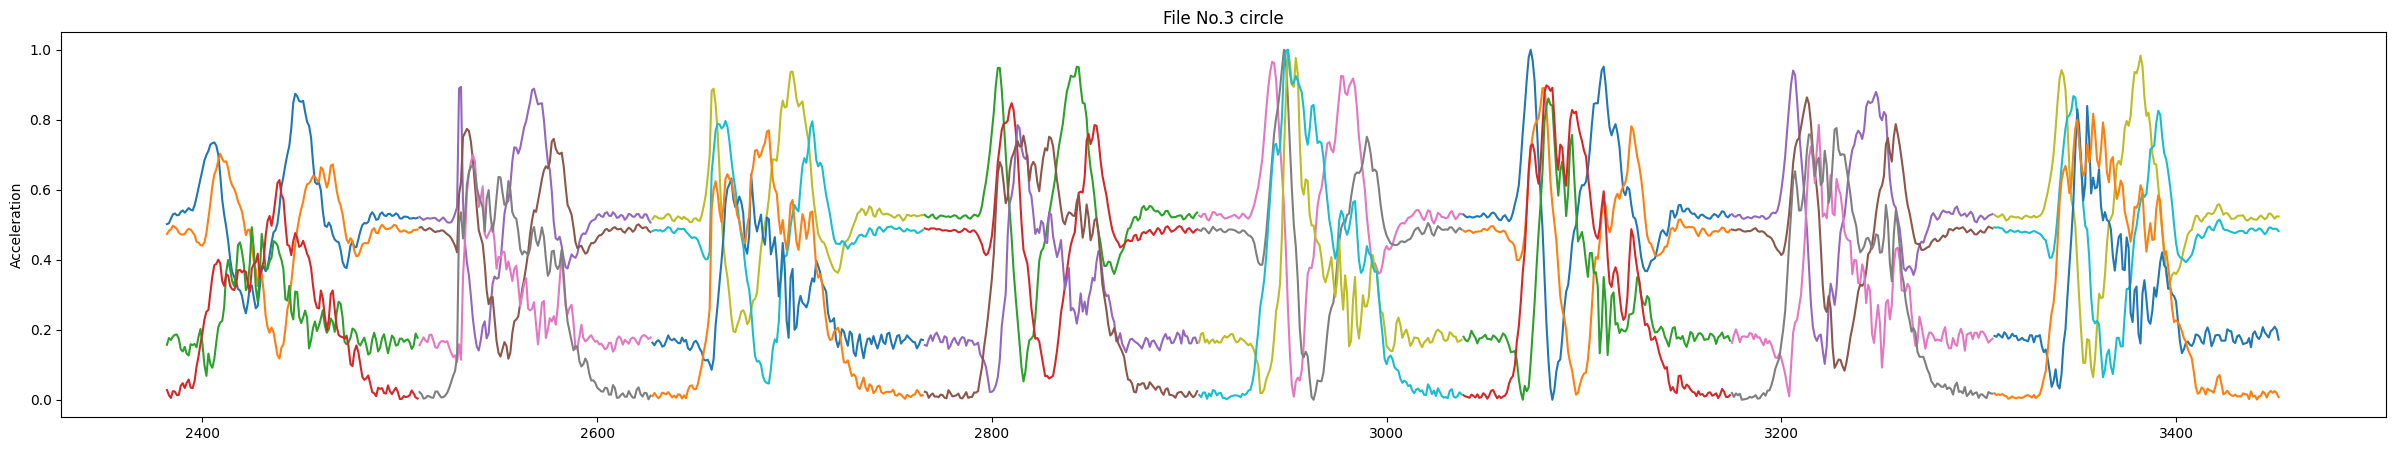

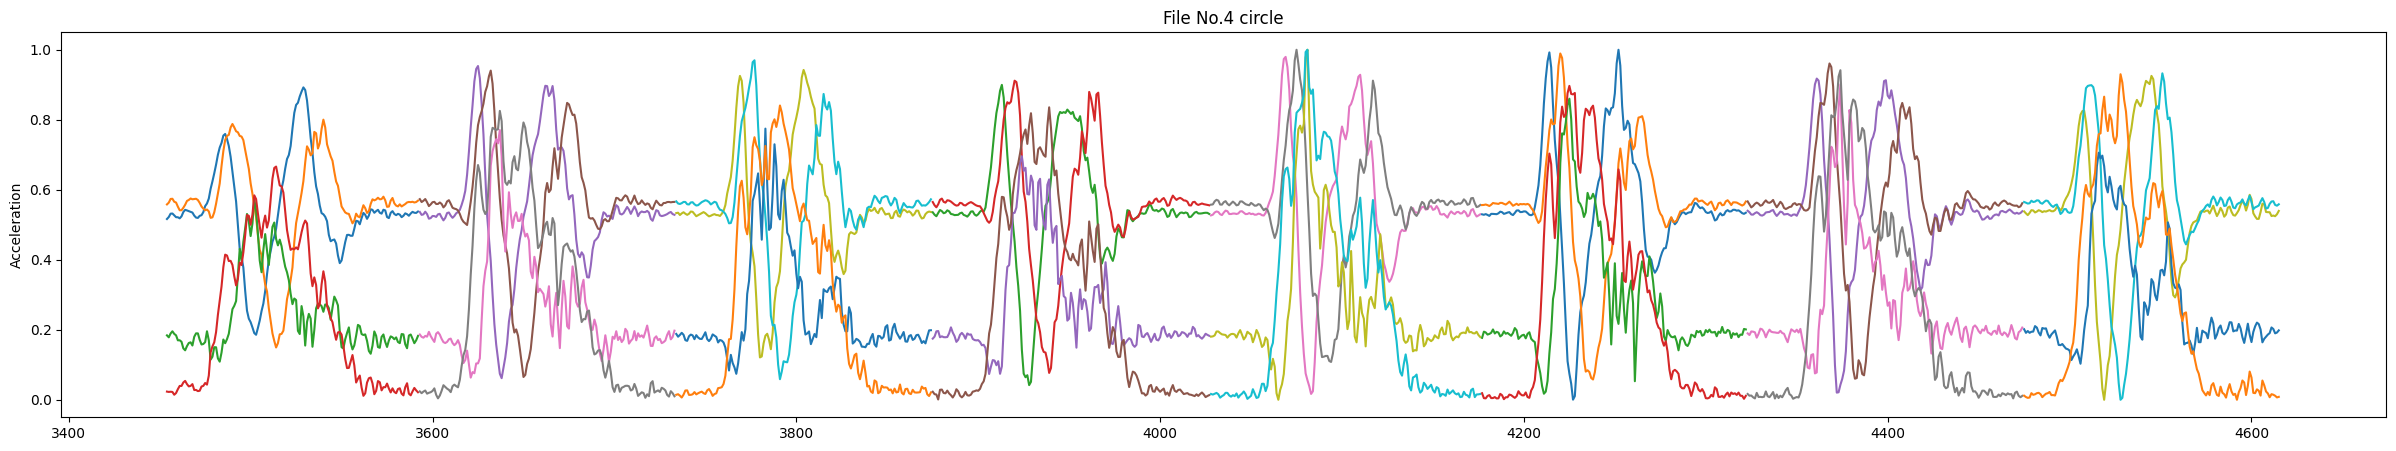

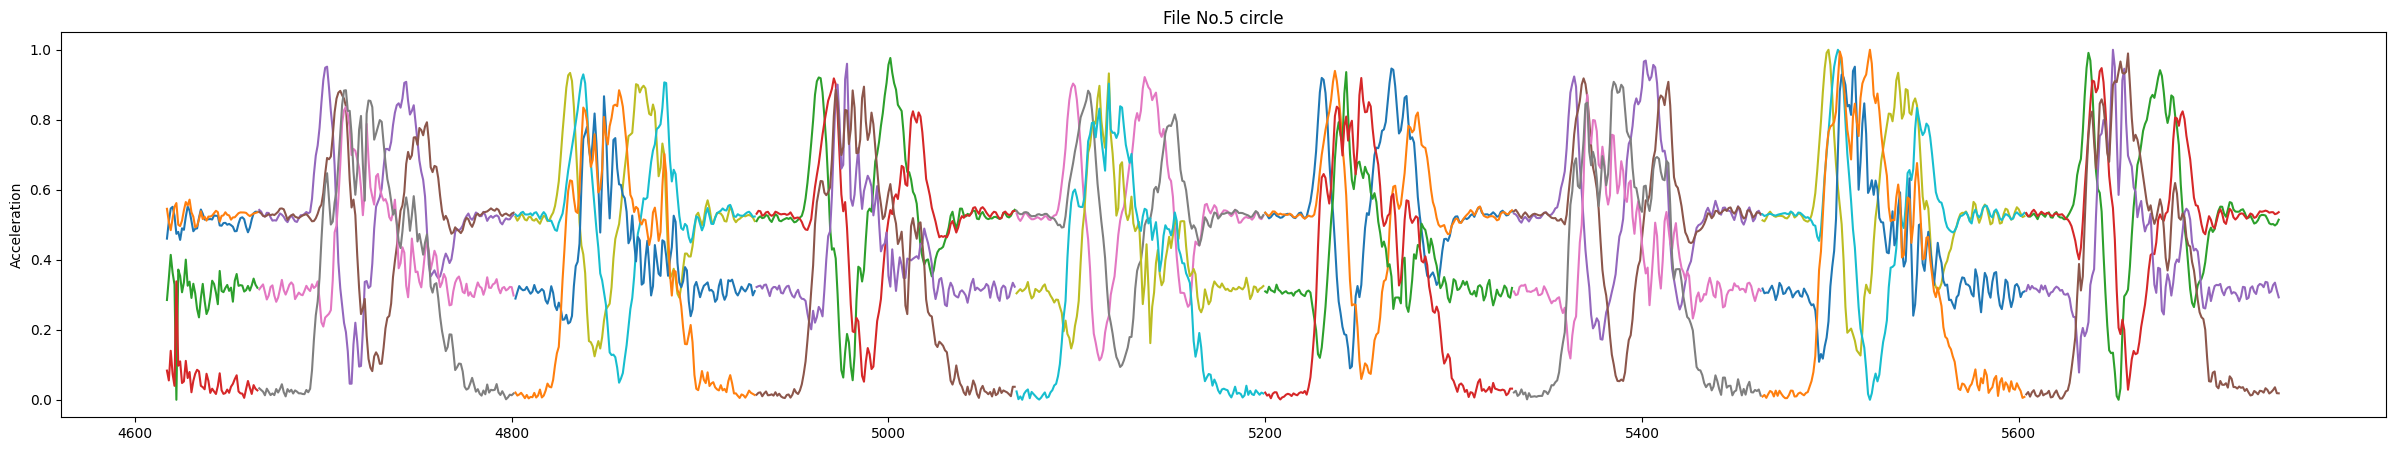

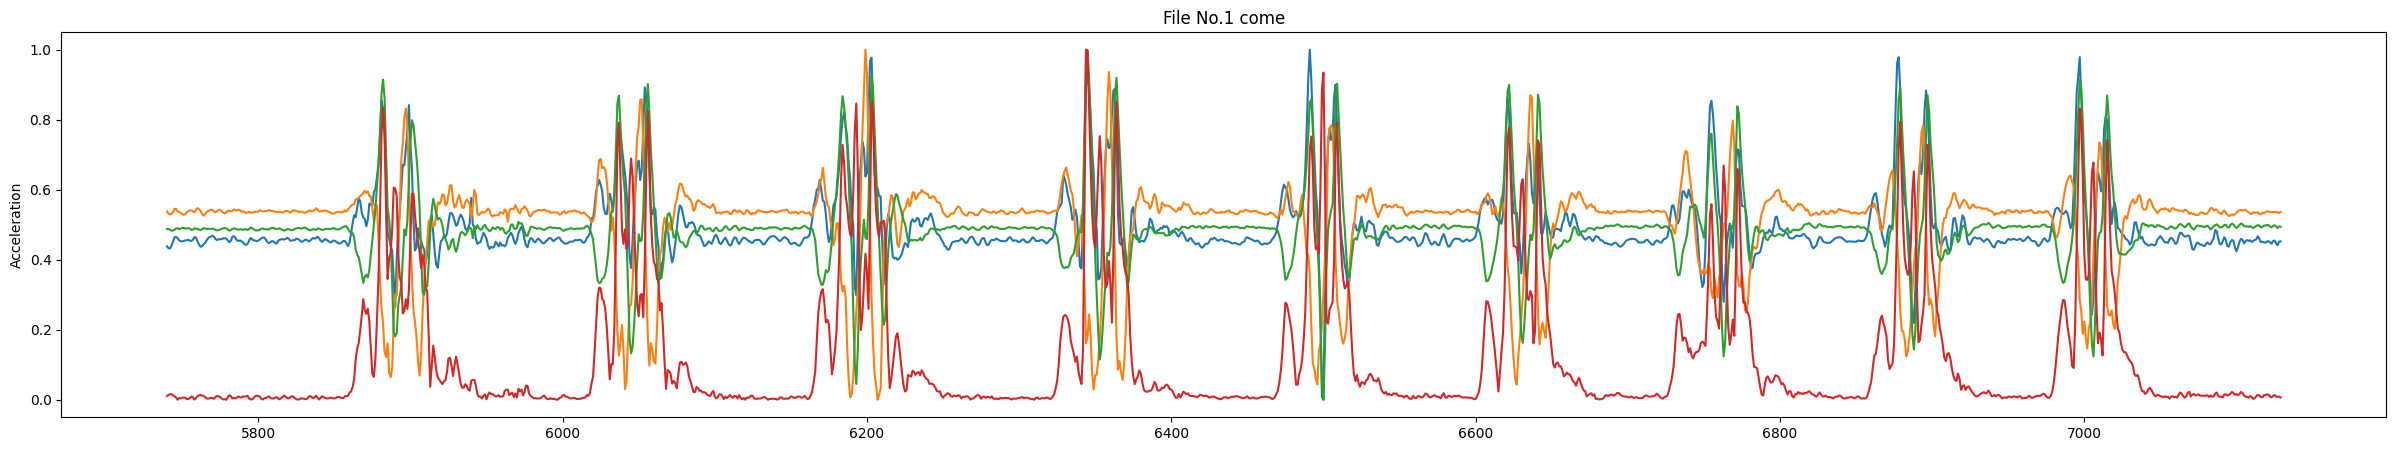

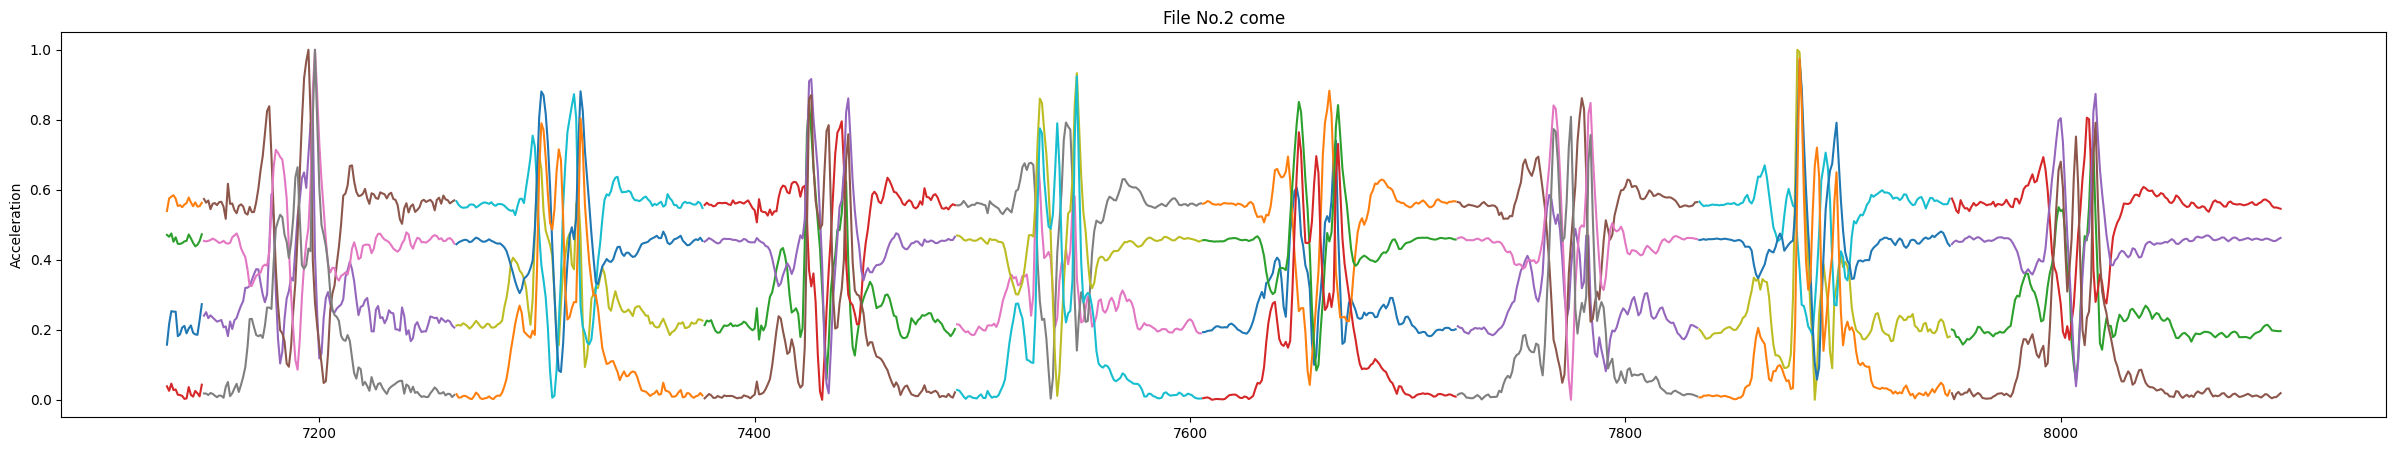

In [9]:
for gesture in get_gestures():
    d = df[df['gesture'] == gesture]
    for i, sub_group in d.groupby('file_number'):

        plt.figure(figsize=(30, 5))

        for gesture_number in sub_group['gesture_number'].unique():
            gesture_group = sub_group[sub_group['gesture_number'] == gesture_number]
            # plt.plot(gesture_group.index, gesture_group['accel_abs'], label=number_to_color(gesture))
        
            for col in get_columns()[1:]:
                plt.plot(gesture_group.index, gesture_group[col], label=number_to_color(gesture_number))

        plt.ylabel('Acceleration')
        plt.title(f'File No.{i} {gesture}')
        plt.show()

KeyError: 4839

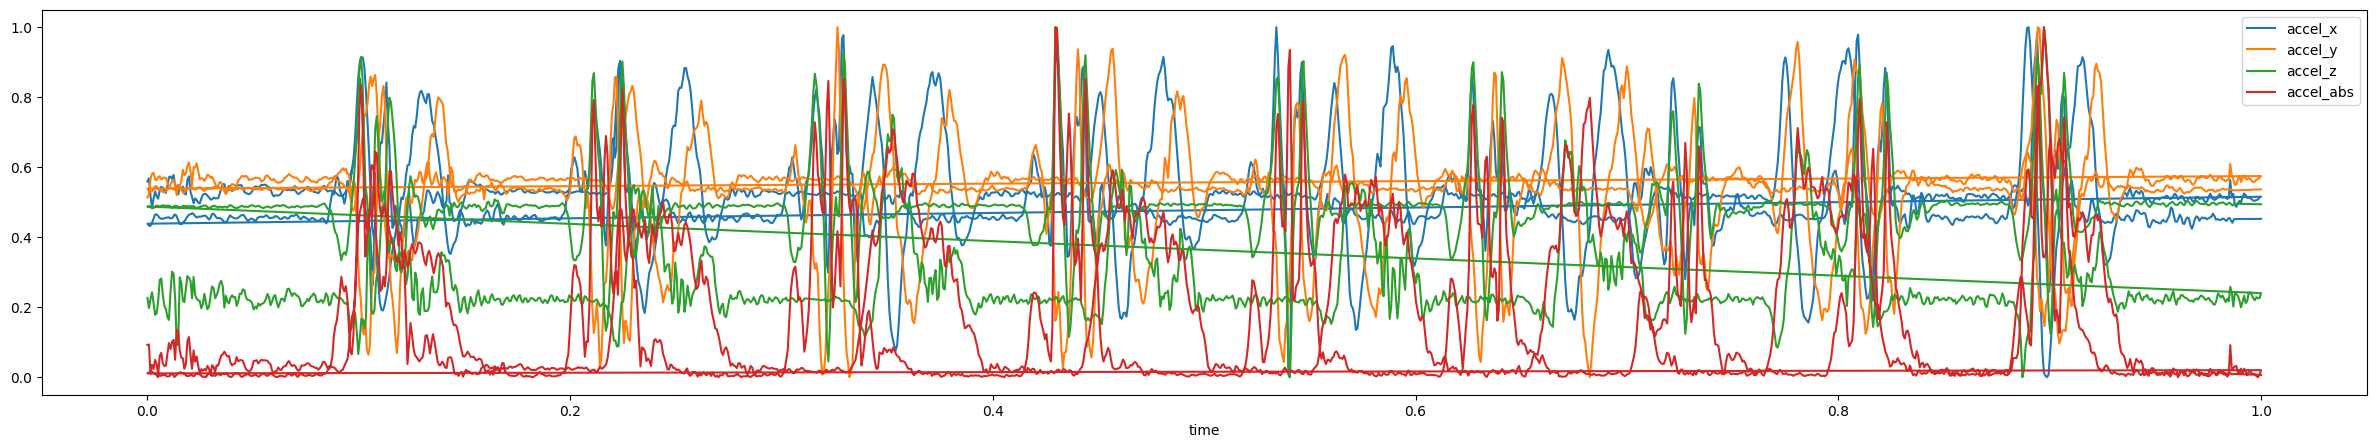

In [10]:
for i, sub_group in df.groupby('file_number'):
      
      sub_group.plot(x='time', y=['accel_x', 'accel_y', 'accel_z', 'accel_abs'], figsize=(30, 5))

      for index in breakpoints:
            plt.axvline(x=sub_group.loc[index, 'time'], color='r', linestyle='--')

      plt.plot(sub_group['time'], sub_group['accel_abs'].rolling(window=rolling_window).std(), label='Rolling Std Dev')
      plt.xlabel('Time')
      plt.ylabel('Acceleration')
      plt.title('Subset Data')
      plt.legend()
      plt.show()  

In [ ]:
def segment_gestures(gesture, threshold = 0.5, column='y', paired=True):
    subset = df[(df['i'] == 1) & (df['g'] == gesture)]

    rolling_std = subset['accel_abs'].rolling(window=10).std()


    crosses_threshold = ((subset[column] > threshold) & (subset[column].shift(1) <= threshold)) | ((subset[column] < threshold) & (subset[column].shift(1) >= threshold))
    crossing_indices = crosses_threshold[crosses_threshold].index.tolist()
    segments = [subset.iloc[start:end] for start, end in zip([0] + crossing_indices, crossing_indices + [len(subset)])]
    if not paired:
        return segments
    
    paired_segments = []
    for i in range(0, len(crossing_indices)-1, 2):
        start = crossing_indices[i]
        end = crossing_indices[i + 2] if i + 2 < len(crossing_indices) else len(subset)
        paired_segments.append(subset.iloc[start:end])
        
    return paired_segments

In [ ]:
def plot_first_n(data, n=10):
    import math 
    plt.figure(figsize=(20, 10))
    
    for i, segment in enumerate(data[:n]):
        plt.subplot(math.ceil(n / 2), 2, i + 1)
        for col in ['x', 'y', 'z', 'abs']:
            plt.plot(segment['time'], segment[col], label=col)
            plt.legend()

    plt.show()

In [ ]:
paired_segments = segment_gestures('circle')
plot_first_n(paired_segments, 10)

In [ ]:
plt.figure(figsize=(40, 10))

for col in ['x', 'y', 'z', 'abs']:
    plt.plot(example_data['time'], example_data[col], label=col)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.axhline(y=threshold, color='black', label='Threshold')

for time_point in starts:
      try: 
            time_values = example_data.loc[time_point, 'time']
            plt.axvline(x=time_values, color='grey', linestyle=':')
      except:
            pass
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

for index, df_group in enumerate(df[df['g'] == 'wave'].groupby(['i', ])):
      plt.subplot(5, 2, index + 1)
      for col in df_group[1].columns[1:5]:
            plt.plot(df_group[1]['time'], df_group[1][col], label=col)
            plt.legend()

In [ ]:
plt.figure(figsize=(20, 10))

for index, df_group in enumerate(df[df['g'] == 'go'].groupby('i')):
      plt.subplot(5, 2, index + 1)
      for col in df_group[1].columns[1:-2]:
            plt.plot(df_group[1]['time'], df_group[1][col], label=col)
            plt.legend()

In [ ]:
# plt.figure(figsize=(20, 10))

# for i, df in enumerate(aligned_dataframes.values()):
#       plt.subplot(5, 2, i + 1)
#       for col in df.columns[1:]:
#             plt.plot(df['time'], df[col], label=col)
#             plt.legend()

In [ ]:
def segment_data(df, window_size, overlap_size, time_column='time', ):
    """
    Segments the data into fixed-size windows.
    
    Parameters:
    - df: DataFrame containing the accelerometer data.
    - window_size: Size of each window in seconds.
    - overlap_size: Size of the overlap between consecutive windows in seconds.
    - time_column: The name of the column containing the timestamp data.
    
    Returns:
    - A list of segmented DataFrames.
    """
    # Convert timestamps to datetime if not already
    df[time_column] = pd.to_datetime(df[time_column], unit='s')
    
    # Sort the dataframe by timestamp to ensure correct window ordering
    df = df.sort_values(by=time_column)
    
    # Calculate the window step size
    step_size = window_size - overlap_size
    
    # Initialize variables
    segments = []
    start_time = df[time_column].min()
    end_time = start_time + pd.Timedelta(seconds=window_size)

    last_time = df[time_column].max()
    
    # Segment the data
    while start_time + pd.Timedelta(seconds=overlap_size) < last_time:
        # Create a mask for the current window
        mask = (df[time_column] >= start_time) & (df[time_column] < end_time)
        segment = df.loc[mask]
        
        if not segment.empty:
            segments.append(segment)
        
        # Update the start and end times for the next window
        start_time += pd.Timedelta(seconds=step_size)
        end_time = start_time + pd.Timedelta(seconds=window_size)
    
    return segments

segmented_data = segment_data(df, window_size=2, overlap_size=1)
print(segmented_data)

for segment in segmented_data:
    segment['label'] = "circle"
    print(segment)
    # plt.figure(figsize=(20, 5))
    # for col in segment.columns[1:-1]:
    #     plt.plot(segment['time'], segment[col], label=col)
    #     plt.legend()

    # plt.show()

In [ ]:
# Example of extracting simple features: mean and standard deviation
def extract_features(segment):
    features = {}
    for axis in ['x', 'y', 'z', 'abs']:
        features[f'{axis}_mean'] = segment[axis].mean()
        features[f'{axis}_std'] = segment[axis].std()
    return features

# Assuming `segments` is a list of your labeled segments (each a DataFrame)
features_list = [extract_features(segment) for segment in segmented_data]
features_df = pd.DataFrame(features_list)
labels = [segment['label'].iloc[0] for segment in segmented_data]  # Assuming each segment has a uniform label
features_df


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)


In [ ]:
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


In [ ]:
def predict_gesture(segment):
    features = extract_features(segment)
    features_df = pd.DataFrame([features])  # Convert to DataFrame to match training shape
    prediction = model.predict(features_df)
    return prediction[0]

# Example: Predict the gesture of a new segment
new_segment = segments[0]  # This should be a new, unseen segment
print(predict_gesture(new_segment))


In [ ]:
for index, segment in enumerate(segmented_data):
    plt.figure(figsize=(10, 6))
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        plt.plot(segment['timestamp'], segment[axis], label=axis)
    plt.legend()
    plt.title(f'Segment {index}')
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()
    
    # Prompt for the label
    label = input(f"Enter label for Segment {index}: ")
    segment['label'] = label

In [ ]:
plt.figure(figsize=(20, 5))
for col in df.columns[1:]:
      plt.plot(df['Time (s)'], df[col], label=col)
      plt.legend()
plt.xticks(np.arange(0, df['Time (s)'].max(), 0.5))
plt.show()


In [ ]:
peaks, _ = find_peaks(df['Gyroscope y (rad/s)'], height=1.5)  # Peaks with height > 0
troughs, _ = find_peaks(-df['Gyroscope y (rad/s)'], height=-1.5)  # Troughs in the inverted data

plt.figure(figsize=(20, 5))
# plt.plot(df['Time (s)'], peaks, label='peaks')  # Plot rolling average

for col in df.columns[1:]:
      rolling_avg = df[col].rolling(window=100).mean()  # Calculate rolling average
      plt.plot(df['Time (s)'], rolling_avg, label=col + ' (Rolling Avg)')  # Plot rolling average
      plt.legend()
plt.xticks(np.arange(0, df['Time (s)'].max(), 0.5))
plt.show()


In [ ]:
# peaks_indices = []

# for dfr in df.groupby(['i', 'g']):
#     signal = dfr[1]['y'].values
#     peaks, _ = find_peaks(signal)
#     peaks_indices.append(peaks)

# reference_peak = 1
# reference_index = peaks_indices[0][reference_peak]

# aligned_dataframes = []
# i = 0

# for dfr in df.groupby(['i', 'g']):

#     shift_amount = reference_index - peaks_indices[i][reference_peak]

#     shifted_signal = np.roll(dfr[1]['y'].values, shift_amount)

#     aligned_df = pd.DataFrame(shifted_signal, columns=['y'])
#     aligned_dataframes.append(aligned_df)
#     i += 1

# aligned_df = pd.concat(aligned_dataframes, ignore_index=True)
# aligned_df